In [1]:
import timeit

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Compile all versions of the stencil2d model

In [2]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

# make clean
make VERSION=sequential

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-sequential.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-sequential.o -o stencil2d-sequential.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-sequential.x' (lite-samples) ...OK


cp stencil2d-sequential.x stencil2d.x


In [3]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

# make clean
make VERSION=random

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-random.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-random.o -o stencil2d-random.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-random.x' (lite-samples) ...OK


cp stencil2d-random.x stencil2d.x


In [4]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

# make clean
make VERSION=hilbert

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-hilbert.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-hilbert.o -o stencil2d-hilbert.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-hilbert.x' (lite-samples) ...OK


cp stencil2d-hilbert.x stencil2d.x


In [5]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

# make clean
make VERSION=base

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-base.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-base.o -o stencil2d-base.x


INFO: creating the PerfTools-instrumented executable 'stencil2d-base.x' (lite-samples) ...OK


cp stencil2d-base.x stencil2d.x


# Run the models with different domain sizes
I run each for loop one by one to avoid too heavy computational load. Just comment out the other loops when running the one you want

In [3]:
gridsize_ls = np.array([16, 32, 64, 128, 256, 512, 1024])

for i in gridsize_ls:
    # sequantial
    output = !srun -n 12 ./stencil2d-sequential.x+orig --nx {i} --ny {i} --nz 64 --num_iter 1024
    print(output.nlstr)
    exec(output.nlstr)

    savedir = "data/runtime_comparison"
    filename = f"data_sequential_{i}x{i}"
    np.save(f"{savedir}/{filename}", data)
    
for i in gridsize_ls:
    # random
    output = !srun -n 12 ./stencil2d-random.x+orig --nx {i} --ny {i} --nz 64 --num_iter 1024
    print(output.nlstr)
    exec(output.nlstr)

    savedir = "data/runtime_comparison"
    filename = f"data_random_{i}x{i}"
    np.save(f"{savedir}/{filename}", data)
    
for i in gridsize_ls:
    # hilbert
    output = !srun -n 12 ./stencil2d-hilbert.x+orig --nx {i} --ny {i} --nz 64 --num_iter 1024
    print(output.nlstr)
    exec(output.nlstr)

    savedir = "data/runtime_comparison"
    filename = f"data_hilbert_{i}x{i}"
    np.save(f"{savedir}/{filename}", data)
    
for i in gridsize_ls:
    # structured
    output = !srun -n 12 ./stencil2d-base.x+orig --nx {i} --ny {i} --nz 64 --num_iter 1024
    print(output.nlstr)
    exec(output.nlstr)

    savedir = "data/runtime_comparison"
    filename = f"data_base_{i}x{i}"
    np.save(f"{savedir}/{filename}", data)

# ranks nx ny ny nz num_iter time
data = np.array( [ \
[   12,   16,   16,   64,    1024,  0.3406290E-01], \
] )
# ranks nx ny ny nz num_iter time
data = np.array( [ \
[   12,   32,   32,   64,    1024,  0.8966817E-01], \
] )
# ranks nx ny ny nz num_iter time
data = np.array( [ \
[   12,   64,   64,   64,    1024,  0.2648436E+00], \
] )
# ranks nx ny ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,    1024,  0.2102895E+01], \
] )
# ranks nx ny ny nz num_iter time
data = np.array( [ \
[   12,  256,  256,   64,    1024,  0.8798674E+01], \
] )
# ranks nx ny ny nz num_iter time
data = np.array( [ \
[   12,  512,  512,   64,    1024,  0.4014422E+02], \
] )
# ranks nx ny ny nz num_iter time
data = np.array( [ \
[   12, 1024, 1024,   64,    1024,  0.3427699E+03], \
] )


# Load data and plot

In [6]:
case_list = ["sequential", "random", "hilbert", "base"]
label_list = ["sequential", "random", "hilbert", "structured"]
gridsize_ls = np.array([16, 32, 64, 128, 256, 512, 1024])
savedir = "data/runtime_comparison"
case_data_list = []

for case in case_list:
    data_list = []
    
    for j in gridsize_ls:
        tmp = np.load(f"{savedir}/data_{case}_{j}x{j}.npy")
        data_list.append(tmp)
        data = np.concatenate(data_list)
    case_data_list.append(data)
    

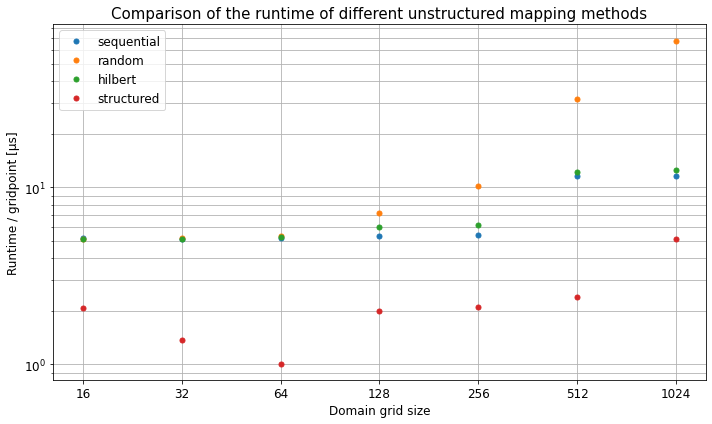

In [7]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()
for i in range(len(case_data_list)):
    data = case_data_list[i]
    domain_size = np.log2(data[:,1])
    runtime_per_gridpoint = data[:,5] / data[:,1] / data[:,2] / data[:,3]
    ax.plot(domain_size, runtime_per_gridpoint * 1.0e6, '.', **{'label':f'{label_list[i]}', 'markersize':10})

ax.set_yscale('log')
ax.grid(visible=True, which='both')
ax.set_title("Comparison of the runtime of different unstructured mapping methods", size=15)
ax.set_xlabel("Domain grid size", size=12)
ax.set_xticks(np.log2(gridsize_ls))
ax.set_xticklabels(gridsize_ls)
ax.set_ylabel( 'Runtime / gridpoint [µs]', size=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(**{'fontsize':12})
fig.tight_layout()
fig.savefig(f"figures/comparison_runtime.png");

clean all exec.

In [8]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean

rm -f *.out weak.txt caching.txt caching2.txt out.txt 
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report report_*.txt out.txt


# check cache report

In [11]:
cache_data_dir = f"{savedir}/cache_report"
!mkdir -p {cache_data_dir}

### Hilbert curve

In [9]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools

make clean
make VERSION=hilbert
pat_build -Drtenv=PAT_RT_PERFCTR=1 -g mpi -u stencil2d-hilbert.x
# start from 128
srun -n 12 ./stencil2d-hilbert.x+pat --nx 128 --ny 128 --nz 64 --num_iter 1024

rm -f *.out weak.txt caching.txt caching2.txt out.txt 
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report report_*.txt out.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-hilbert.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-hilbert.o -o stencil2d-hilbert.x
cp stencil2d-hilbert.x stencil2d.x


CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,    1024,  0.6313039E+01], \
] )


Experiment data directory written:
/users/class164/Submission/stencil2d-hilbert.x+pat+434-3875t


In [10]:
%%bash
pat_report -o report.txt stencil2d-hilbert.x+pat+*

Processing step 11 of 11


In [12]:
!mv report.txt {cache_data_dir}/report_hilbert.txt

### sequential

In [15]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools

make clean
make VERSION=sequential
pat_build -Drtenv=PAT_RT_PERFCTR=1 -g mpi -u stencil2d-sequential.x
# start from 128
srun -n 12 ./stencil2d-sequential.x+pat --nx 128 --ny 128 --nz 64 --num_iter 1024

rm -f *.out weak.txt caching.txt caching2.txt out.txt 
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report report_*.txt out.txt
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-sequential.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-sequential.o -o stencil2d-sequential.x
cp stencil2d-sequential.x stencil2d.x


CrayPat/X:  Version 21.09.0 Revision b02949528  08/17/21 03:14:02


# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,    1024,  0.5492527E+01], \
] )


Experiment data directory written:
/users/class164/Submission/stencil2d-sequential.x+pat+1210-3875t


In [16]:
%%bash
pat_report -o report.txt stencil2d-sequential.x+pat+*

Processing step 11 of 11


In [17]:
!mv report.txt {cache_data_dir}/report_sequential.txt

clean all exec.

In [18]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean

rm -f *.out weak.txt caching.txt caching2.txt out.txt 
rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report report_*.txt out.txt
